Consider a 1-D chain of bursting neurons coupled to a single inhibitory cell.

Assume each cell is coupled to its successor with weight $W_{ee}$ and that each cell is coupled to the I cell with weight $W_{ei}$. Assume the I cell is coupled to all cells in the chain with weight $W_{ie}$.

If activity in the chain has reached steady (propagating state), then the average drive to the I cell is:

$$ I_{ei} = W_{ei} f_e p t_b $$

where $f_e$ is the burst frequency of the bursting cells, $p$ is the number of cells bursting per second (or the propagation speed), and $t_b$ is the duration of the burst for each bursting cell.

To calculate the average firing rate of the I cell, we begin with the equation for the voltage of a current-coupled neuron driven by a constant current:

$$ V(t) = \frac{1}{C_i}\int_{0}^{t} e^{-(t-t')/\tau_i} I_{ei} dt'$$

$$ V_{th}^{i} = \frac{I_{ei}}{C_i} \tau_i \left(1 - e^{-t/\tau_i}\right) $$

This implies the average time to fire is:

$$ t^*_i = -\tau_i \log \left( 1 - \frac{V_{th}^{i} C_i}{I_{ei} \tau_i} \right) $$

This implies firing rate $f_i$:

$$ f_i = \frac{-1}{\tau_i \log \left( 1 - \frac{V_{th}^{i} C_i}{W_{ei} f_e p t_b \tau_i} \right)} $$

Now we turn to calculating the time-to-fire of a bursting cells that is just beginning to receive input from its predecessor. We assume steady state, so this cell has been receiving constant inhibitory spikes of frequency $f_i$ for a long time. Therefore, we have:

$$ V_{th}^{e} - \frac{W_{ie} f_i \tau_e}{C_e} = \frac{1}{C_e}\int_0^{t^*_e} e^{-(t-t')/\tau_e} W_{ee} f_e dt'$$


$$ V_{th}^{e} - \frac{W_{ie} f_i \tau_e}{C_e} = \frac{\tau_e}{C_e} (1 - e^{-t^*_e/\tau_e} ) W_{ee} f_e$$

Rearranging, this yields:

$$ t^*_e = -\tau_e \log \left(1 - \frac{C_e (V_{th}^{e} - \frac{W_{ie} f_i \tau_e}{C_e})}{\tau_e W_{ee} f_e }\right)$$

This implies:

$$ p_{out} = \frac{-1}{\tau_e \log \left(1 - \frac{C_e (V_{th}^{e} - \frac{W_{ie} f_i \tau_e}{C_e})}{\tau_e W_{ee} f_e }\right) }$$

where $f_i$ is a function of $p$.

We then write:
    
$$ p_{out} = p + \Delta p $$

This yields:

$$ p + \Delta p = \frac{-1}{\tau_e \log \left(1 - \frac{C_e (V_{th}^{e} - \frac{W_{ie} f_i \tau_e}{C_e})}{\tau_e W_{ee} f_e }\right) }$$

$$ \Delta p = \frac{-1}{ \tau_e \log \left(1 - \frac{C_e (V_{th}^{e} - \frac{W_{ie} f_i \tau_e}{C_e})}{\tau_e W_{ee} f_e }\right)} - p$$

We set $\Delta p = 0$ to find fixed points. 

### Calculation of stable values of p for different values of recurrent inhibition

In [1]:
%matplotlib inline
from copy import deepcopy as copy
import matplotlib.gridspec as gridspec
import matplotlib.pyplot as plt
import matplotlib
import numpy as np
from scipy import stats
import scipy.io as sio
import pandas as pd
from tqdm import tqdm
import pickle
from collections import OrderedDict
import os
from scipy.ndimage.interpolation import shift
from functools import reduce
import time

import warnings
warnings.filterwarnings("ignore", category=RuntimeWarning) 

In [2]:
dt = 5e-5
tau_e = 4e-3
tau_i = 4e-3
v_th_e = 20e-3
v_th_i = 20e-3
c_e = 1e-6
c_i = 1e-6
t_b = 10e-3
f_e = 5e3

w_ee = 1.2e-5
w_ei = 1e-8

In [16]:
def f_i(p, u=0, alpha=1.):
    x = v_th_i * c_i / (tau_i * (w_ei * alpha * f_e * t_b * p + u))
    return -1 / (tau_i * np.log(1 - x))

def dp(p, u=0, alpha=1, u_e=0):
    x = c_e * (v_th_e - w_ie * f_i(p, u, alpha) * tau_e / c_e) / (tau_e * (w_ee * alpha * f_e + u_e))
    delta_p = -1 / (tau_i * np.log(1 - x)) - p
    return np.where(x <= 1, delta_p, 0)

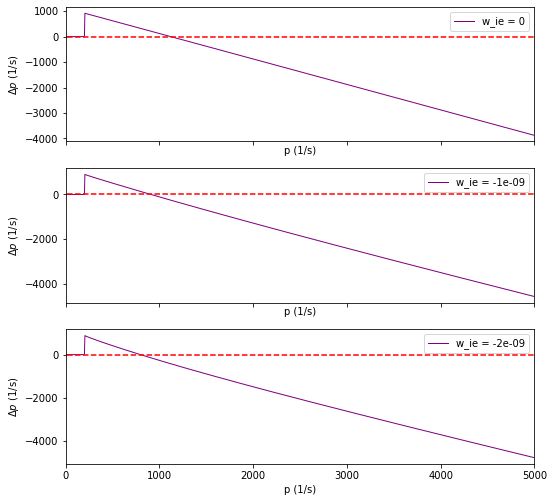

In [17]:
scale = 1.4
fig, axs = plt.subplots(3, 1, sharex=True, sharey=False, figsize=(6 * scale, 6 * scale))
for i, w_ie in enumerate([0, -1e-9, -2e-9]):
    p = np.linspace(10, 5000, 1000)
    axs[i].plot(p, dp(p), lw=1., label=f'w_ie = {w_ie}', c='purple')
    axs[i].set_xlabel('p (1/s)')
    axs[i].set_ylabel(r'$\Delta p$ (1/s)')
    axs[i].plot(p, [0] * len(p), '--', c='red')
    axs[i].set_xlim(0, 5000)
    axs[i].legend()
plt.show()

### Controling p with uva input

Now, supply the I cell with an additional excitatory input $u$. The equation for $f_i$ is now:

$$ f_i = \frac{-1}{\tau_i \log \left( 1 - \frac{V_{th}^{i} C_i}{\tau_i (W_{ei} f_e p t_b + u)} \right)} $$

This provides a means for controlling the propagation speed of the E cells.

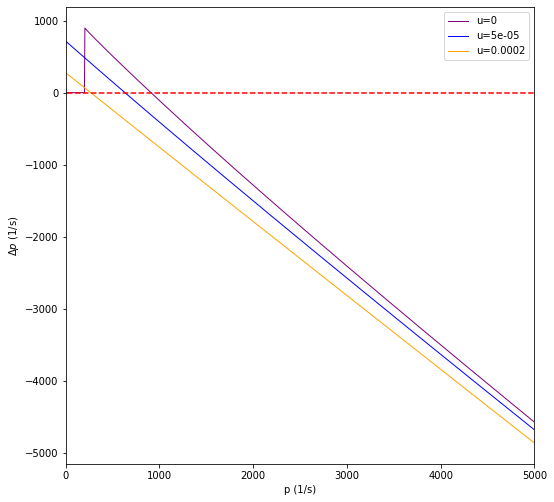

In [18]:
scale = 1.4
fig, axs = plt.subplots(1, 1, sharex=True, sharey=False, figsize=(6 * scale, 6 * scale))

w_ie = -1e-9
colors = ['purple', 'blue', 'orange']

for i, u in enumerate([0, 0.5e-4, 2e-4]):
    p = np.linspace(10, 5000, 1000)
    axs.plot(p, dp(p, u), lw=1., label=f'u={u}', c=colors[i])
axs.set_xlabel('p (1/s)')
axs.set_ylabel(r'$\Delta p$ (1/s)')
axs.plot(p, [0] * len(p), '--', c='red')
axs.set_xlim(0, 5000)
axs.legend()
plt.show()

### Why bother with the recurrent inhibitory loop?

Uva could just as easily directly inhibit or excite the chain itself. However, a chain without recurrent inhibition changes propagation speed when E cells die. To explore this, we modulate $W_{ei}$ and $W_{ee}$ by a factor $\alpha$ to explore the effect of hypothetical E cell death.

### Propagation speed fixed points of a chain for different values of $\alpha$ and Uva input )

#### 1. With recurrent inhibition and Uva exciting the I cell:

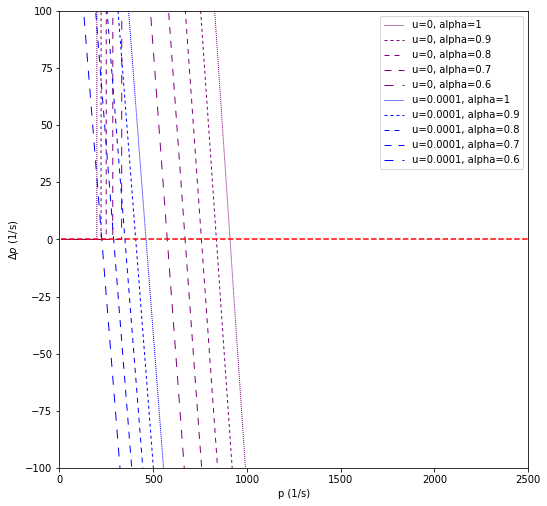

In [19]:
scale = 1.4
fig, axs = plt.subplots(1, 1, sharex=True, sharey=False, figsize=(6 * scale, 6 * scale))

w_ie = -1e-9

colors = ['purple', 'blue']

for i, u in enumerate([0, 1e-4]):
    for j, alpha in enumerate([1, 0.9, 0.8, 0.7, 0.6]):
        p = np.linspace(10, 2500, 1000)
        line, = axs.plot(p, dp(p, u, alpha), lw=1., dashes = ([2 * j + 1] * 4), label=f'u={u}, alpha={alpha}', c=colors[i])
axs.set_xlabel('p (1/s)')
axs.set_ylabel(r'$\Delta p$ (1/s)')
axs.plot(p, [0] * len(p), '--', c='red')
axs.set_xlim(0, 2500)
axs.set_ylim(-100, 100)
axs.legend()
plt.show()

Here we see that the effect of the uva input is roughly preserved after we rescale $W_{ee}$ and $W_{ei}$ by $\alpha$: the additional input roughly halves the propagation speed.

#### 2. Without recurrent inhibition and direct inhibition of chain from Uva:

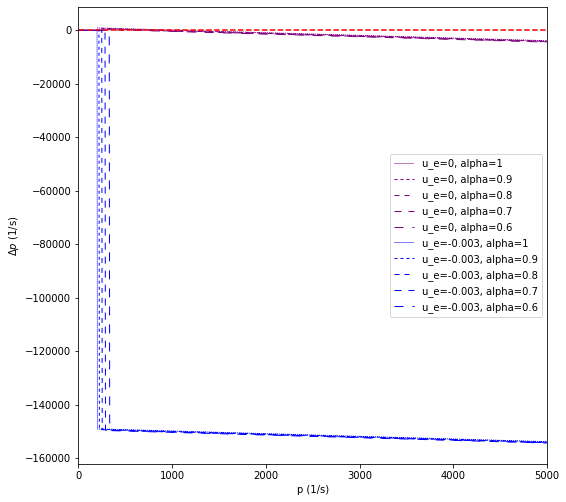

In [20]:
scale = 1.4
fig, axs = plt.subplots(1, 1, sharex=True, sharey=False, figsize=(6 * scale, 6 * scale))

w_ie = 0

colors = ['purple', 'blue']

for i, u_e in enumerate([0, -3e-3]):
    for j, alpha in enumerate([1, 0.9, 0.8, 0.7, 0.6]):
        p = np.linspace(10, 5000, 1000)
        axs.plot(p, dp(p, 0, alpha, u_e=u_e), lw=1., dashes=([2 * j + 1] * 4), label=f'u_e={u_e}, alpha={alpha}', c=colors[i])
axs.set_xlabel('p (1/s)')
axs.set_ylabel(r'$\Delta p$ (1/s)')
axs.plot(p, [0] * len(p), '--', c='red')
axs.set_xlim(0, 5000)
axs.legend()
plt.show()

Here, we see that the effect of the uva input is not preserved after rescaling by alpha.

In [21]:
from ntwk import LIFNtwkI
from aux import *
import matplotlib.gridspec as gridspec
import matplotlib.pyplot as plt

In [26]:
# PARAMS
## NEURON AND NETWORK MODEL
M = Generic(
    # Excitatory membrane
    C_M_E=1e-6,  # membrane capacitance
    G_L_E=.25e-3,  # membrane leak conductance (T_M (s) = C_M (F/cm^2) / G_L (S/cm^2))
    E_L_E=-.07,  # membrane leak potential (V)
    V_TH_E=-.05,  # membrane spike threshold (V)
    T_R_E=10e-3,  # refractory period (s)
    T_R_I=0,
    E_R_E=-0.07, # reset voltage (V)
    
    # Inhibitory membrane
    #C_M_I=1e-6,
    #G_L_E=.1e-3, 
    #E_L_I=-.06,
    #V_TH_E=-.05,
    #T_R_I=.002,
    
    N_EXC=100,
    N_INH=1,
    
    # OTHER INPUTS
    SGM_N=.5e-10,  # noise level (A*sqrt(s))
    I_EXT_B=0,  # additional baseline current input
    
    W_E_E = 1e-4,
    W_E_I = 1e-5,
    W_I_E = -2e-4,
    W_U_E = 5e-4,
    
    F_B = 5e3,
    T_B = 10e-3,
)

t_r = M.T_R_E * np.ones((M.N_EXC + M.N_INH))
t_r[-1] = M.T_R_I

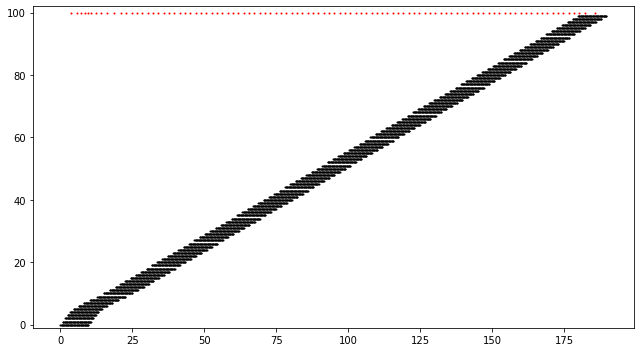

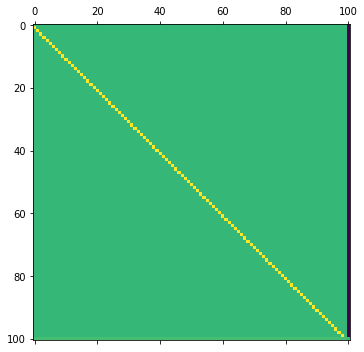

In [27]:
w_r = np.block([
    [ M.W_E_E * np.diag(np.ones((M.N_EXC - 1)), k=-1), M.W_I_E * np.ones((M.N_EXC, M.N_INH)) ],
    [ M.W_E_I * np.ones((M.N_INH, M.N_EXC)), np.zeros((M.N_INH, M.N_INH)) ],
])

w_u = np.zeros((M.N_EXC + M.N_INH, 1))
w_u[0, 0] = M.W_U_E

i_b = np.ones((M.N_EXC + M.N_INH), dtype=int)
i_b[-1] = 0

ntwk = LIFNtwkI(
    c_m = M.C_M_E,
    g_l = M.G_L_E,
    e_l = M.E_L_E,
    v_th = M.V_TH_E,
    v_r = M.E_R_E,
    t_r = t_r,
    w_r = w_r,
    w_u = w_u,
    i_b = i_b,
    f_b = M.F_B,
    t_b = M.T_B)

S = Generic(RNG_SEED=0, DT=dt)
t = np.arange(0, .5, S.DT)

spks_u = np.zeros((len(t), 1), dtype=int)
spks_u[0, 0] = 1

rsp = ntwk.run(
    dt=S.DT,
    clamp=Generic(v={0: M.E_L_E * np.ones((M.N_EXC + M.N_INH))}, spk={}),
    i_ext=np.zeros(len(t)),
    spks_u=spks_u)

raster = np.stack([rsp.spks_t, rsp.spks_c])
inh_raster = raster[:, raster[1, :] >= M.N_EXC]
exc_raster = raster[:, raster[1, :] < M.N_EXC]

scale = 1.
gs = gridspec.GridSpec(1, 1)
fig = plt.figure(figsize=(9 * scale, 5 * scale), tight_layout=True)
axs = [fig.add_subplot(gs[0])]

axs[0].scatter(exc_raster[0, :] * 1000, exc_raster[1, :], c='black', s=1)
axs[0].scatter(inh_raster[0, :] * 1000, inh_raster[1, :], c='red', s=1)

axs[0].set_ylim(-1, 102)

scale = 1.
gs = gridspec.GridSpec(1, 1)
fig = plt.figure(figsize=(9 * scale, 5 * scale), tight_layout=True)
axs = [fig.add_subplot(gs[0])]

axs[0].matshow(w_r)

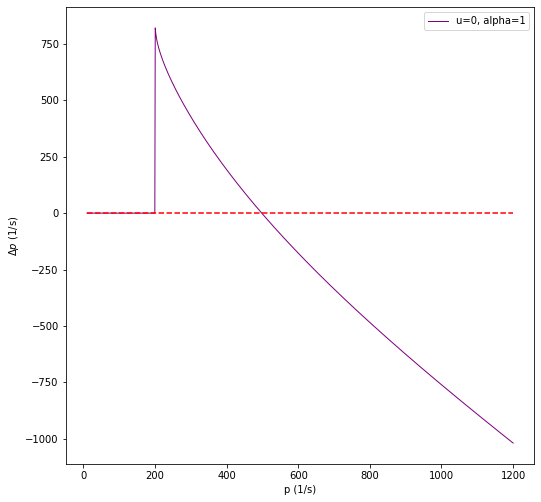

In [28]:
scale = 1.4
fig, axs = plt.subplots(1, 1, sharex=True, sharey=False, figsize=(6 * scale, 6 * scale))

w_ee = M.W_E_E * dt
w_ei = M.W_E_I * dt
w_ie = M.W_I_E * dt
f_b = M.F_B
t_b = M.T_B

colors = ['purple', 'blue']

for i, u in enumerate([0]):
    for j, alpha in enumerate([1]):
        p = np.linspace(10, 1200, 1000)
        line, = axs.plot(p, dp(p), lw=1., label=f'u={u}, alpha={alpha}', c='purple')
axs.set_xlabel('p (1/s)')
axs.set_ylabel(r'$\Delta p$ (1/s)')
axs.plot(p, [0] * len(p), '--', c='red')
axs.legend()
plt.show()